### Imports

In [ ]:
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.datasets import load_intrusion
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext snakeviz

In [ ]:
data, bb = load_intrusion()

In [ ]:
fault_data = data[data['type']=='fault']

In [ ]:
fault_data

In [ ]:
model = GeologicalModel(bb[0,:],bb[1,:])
model.set_model_data(fault_data)
fault = model.create_and_add_fault('fault',
                                   -600,
                                   nelements=2000,
                                   steps=4,
                                   interpolatortype='PLI',
                                  buffer=0.3
                                  )


In [ ]:
bedding_val = np.random.random((40,4))
bedding_val[:,0]*=bb[1,0]
bedding_val[:,1]*=bb[1,1]
bedding_val[:,2]=-600
bedding_val[:,3]=0
bedding_val = np.vstack([bedding_val,bedding_val])
bedding_val[40:,2]-=-500
bedding_val[40:,3]= -1
# print(bedding_val)
# print(fault['feature'].evaluate(model.scale(bedding_val)))
bedding_val[:,:3] = model.rescale(fault['feature'].apply_to_points(model.scale(bedding_val[:,:3])))

# print(bedding_val)

In [ ]:
new_data = pd.DataFrame(bedding_val,columns=['X','Y','Z','val'])
new_data['type'] = 'strati'
# new_data['val'] = 0

In [ ]:
# normal_vec = pd.DataFrame([[9000,10,10,0,0,1]],columns=['X','Y','Z','nx','ny','nz'])
# normal_vec['type'] = 'strati'

data = pd.concat([fault_data,new_data],sort=False)
data

In [ ]:
bb

In [ ]:
# %%snakeviz
# for i in range(10):
model = GeologicalModel(bb[0,:],bb[1,:])
model.set_model_data(data)
fault = model.create_and_add_fault('fault',
                                   600,
                                   nelements=2000,
                                   steps=4,
                                   interpolatortype='PLI',
                                  buffer=0.3,
                                   solver='pyamg'
                                  )
strati = model.create_and_add_foliation('strati',
                                        nelements=10000,
                                        interpolatortype='PLI',
                                        cgw=0.1,
                                        solver='pyamg',
                                        buffer=0.5
                                       )

viewer = LavaVuModelViewer(model)
viewer.add_isosurface(strati['feature'],isovalue=0)
viewer.add_isosurface(fault['feature'],isovalue=0)
# viewer.add_scalar_field(fault['feature'].displacementfeature)
viewer.add_vector_field(fault['feature'][1],locations=model.regular_grid()[::100,:])
viewer.add_data(strati['feature'])
# viewer.add_points(strati['feature'].get_interpolator()[:,:3],pts)
viewer.interactive()

In [ ]:
viewer = LavaVuModelViewer(model)
viewer.add_isosurface(strati['feature'],isovalue=0)
viewer.add_isosurface(fault['feature'],isovalue=0)
# viewer.add_scalar_field(fault['feature'].displacementfeature)
viewer.add_vector_field(fault['feature'][1],locations=model.regular_grid()[::100,:])
viewer.add_data(strati['feature'])
viewer.add_points(strati['feature'].get_interpolator().get_value_constraints()[:,:3],name='pts',pointsize=10)
viewer.interactive()


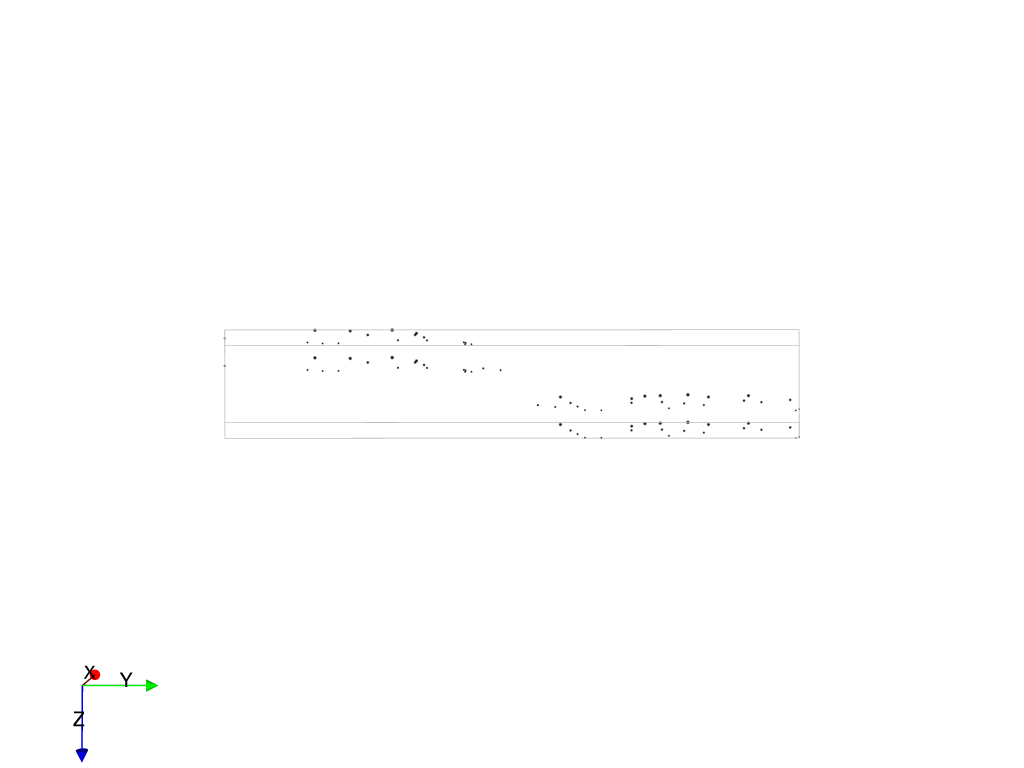


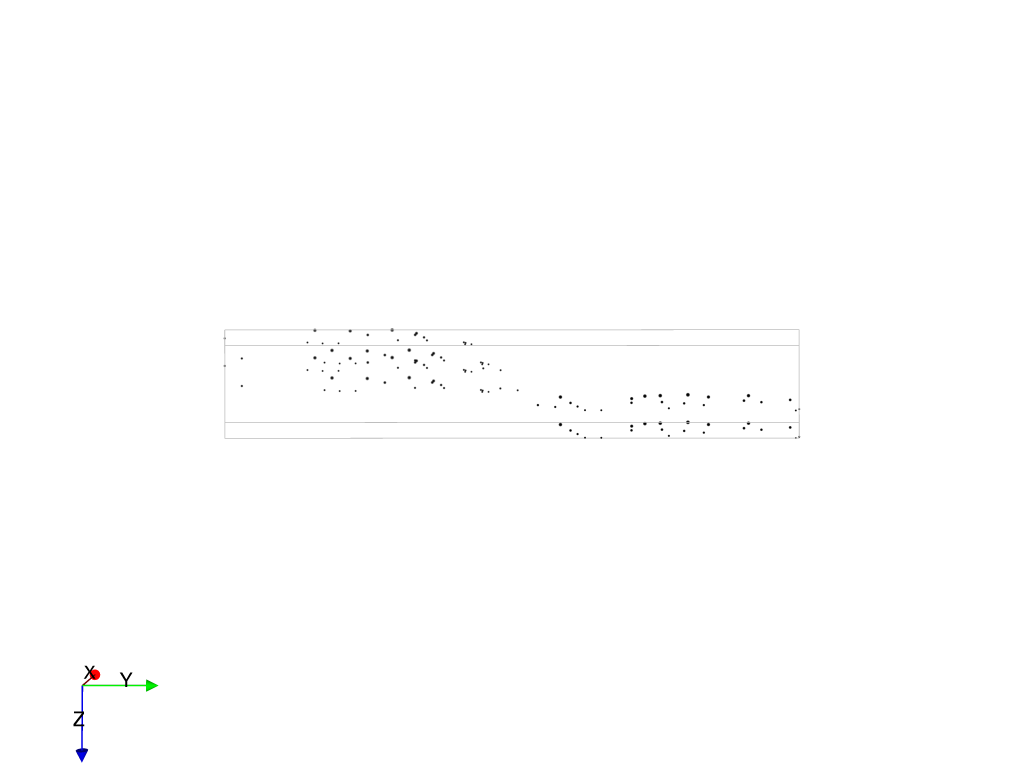


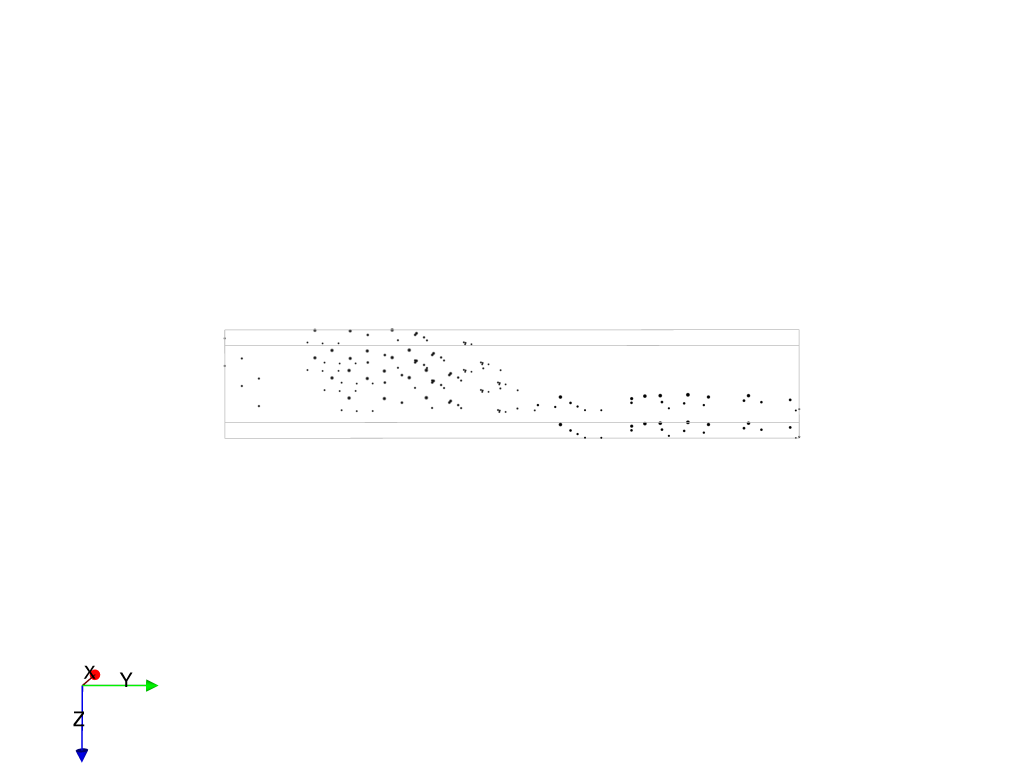


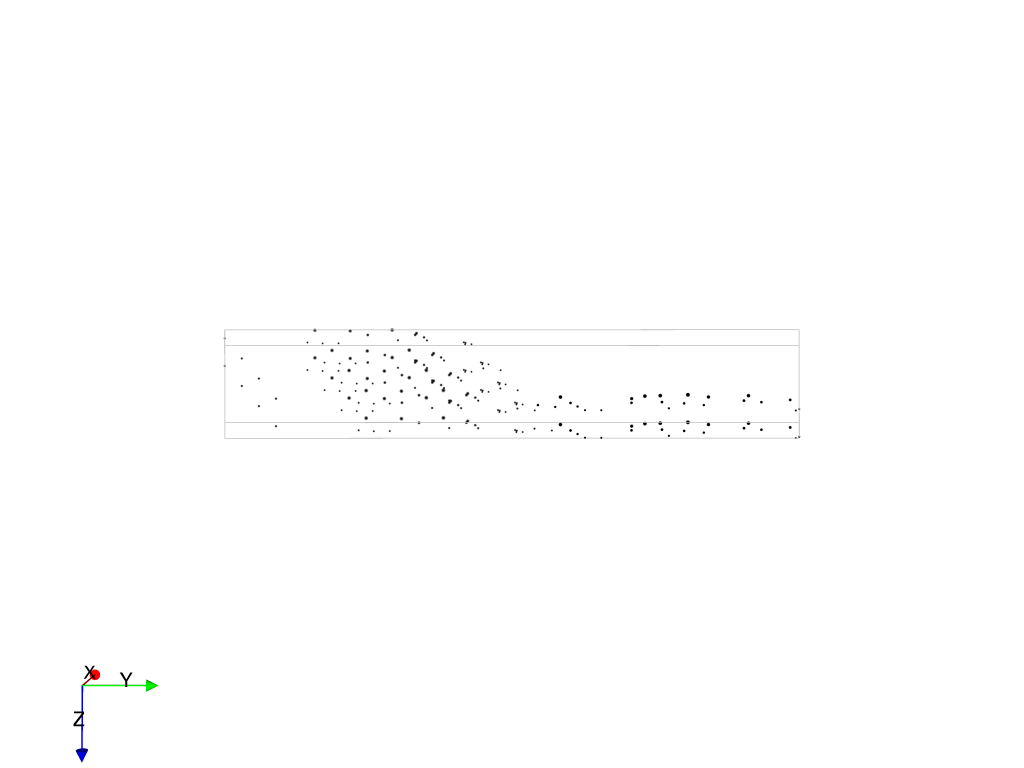


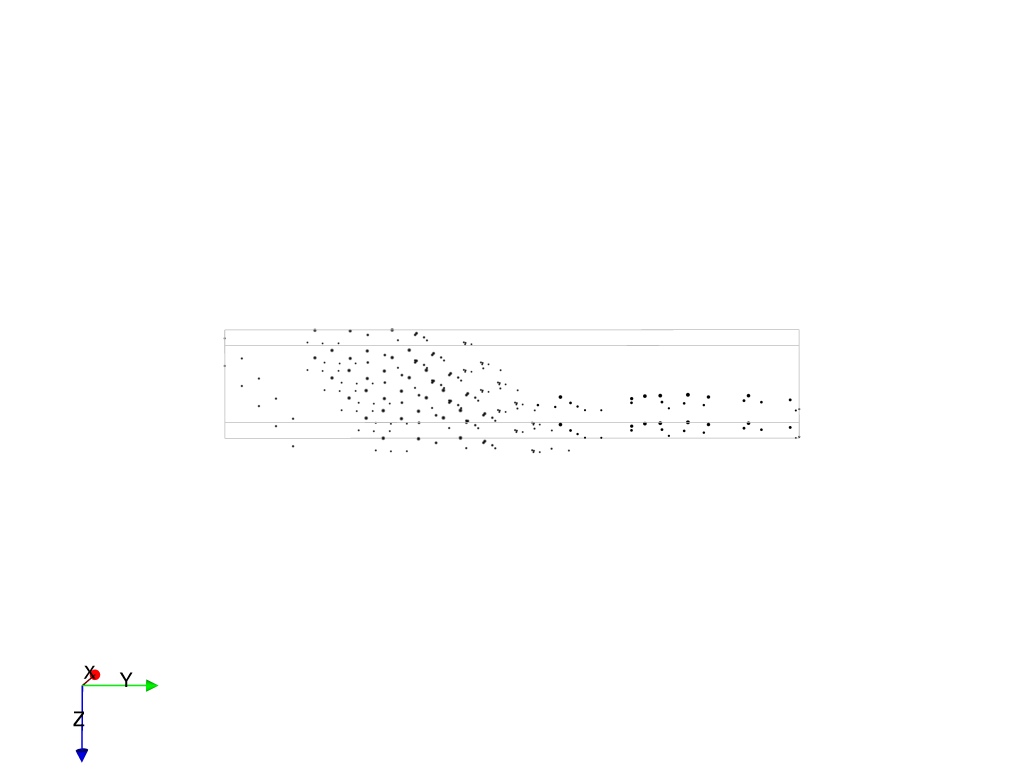

In [26]:
model = GeologicalModel(bb[0,:],bb[1,:],reuse_supports=True)
model.set_model_data(data)
displacement = -700
viewer = LavaVuModelViewer(model)
viewer.rotate([0.019632680341601372, 88.20027923583984, -89.94925689697266])#lv.rotatex(90)

fault = model.create_and_add_fault('fault',
                                   displacement,
                                   nelements=2000,
                                   steps=4,
                                   interpolatortype='PLI',
                                  buffer=0.3,
                                   solver='lu'
                                  )
dist = []
for displacement in [-1000,-500,0,500,1000]:
#     print("displacement: {}".format(displacement))
    fault['feature'].set_displacement(displacement)
#     print('one')
    strati = model.create_and_add_foliation('strati',
                                            nelements=10000,
                                            interpolatortype='PLI',
                                            cgw=0.1,
                                            solver='lu',
                                            buffer=0.5
                                           )
    
#     print('two')
#     plt.figure()
#     print(np.sum(np.abs(strati['feature'].evaluate_value_misfit())))

# #     strati['feature'].faults_enabled = False#toggle_faults()
#     viewer.add_isosurface(strati['feature'],slices=[-1,0])
#     viewer.add_isosurface(fault['feature'][0],isovalue=0)
#     viewer.add_data(strati['feature'])
    viewer.add_points(strati['feature'].get_interpolator().get_value_constraints()[:,:3],name='points_{}'.format(displacement)
                      ,pointsize=3)
#     #viewer.lv.rotatey(90)
    viewer.display()

In [ ]:
# viewer = LavaVuModelViewer(model)
# viewer.add_isosurface(strati['feature'],isovalue=0)
# viewer.add_isosurface(fault['feature'][0],isovalue=0)
# viewer.add_data(strati['feature'])
# viewer.rotate([0.019632680341601372, 88.20027923583984, -89.94925689697266])#lv.rotatex(90)
# #viewer.lv.rotatey(90)
# viewer.display()

In [ ]:
plt.plot([-1000,-500,0,500,1000],dist,'bo')

In [ ]:
# viewer.lv['xyzrotate']

In [86]:
def planeFit(points):
    """
    p, n = planeFit(points)

    Given an array, points, of shape (d,...)
    representing points in d-dimensional space,
    fit an d-dimensional plane to the points.
    Return a point, p, on the plane (the point-cloud centroid),
    and the normal, n.
    """
    import numpy as np
    from numpy.linalg import svd
    #points = points.T
    #print('p',points.shape)
#     points = np.reshape(points, (np.shape(points)[0], -1)) # Collapse trialing dimensions
    assert points.shape[0] <= points.shape[1], "There are only {} points in {} dimensions.".format(points.shape[1], points.shape[0])
    ctr = points.mean(axis=1)
    x = points - ctr[:,np.newaxis]
    M = np.dot(x, x.T) # Could also use np.cov(x) here.
    U,S,V = svd(M)
    normal = V[-1]
    d = -np.sum(normal*ctr)
    return np.hstack([normal,[d]])

def planeDistance(points):
    params = planeFit(points)
    a, b, c, d = params
    x, y, z = points
    length = np.sqrt(a**2 + b**2 + c**2)
    return (np.abs(a * x + b * y + c * z + d) / length).mean()



In [87]:
import emcee

In [88]:
def log_prior(theta):
    displacement, sigma, mu = theta
#     mu = 0
    if sigma <= 0:
        return -np.inf
    if mu <= 0:
        return -np.inf
    prob = -np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(displacement-mu)**2/sigma**2 - np.log(sigma) - np.log(mu)
#     print()
    return -np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(displacement-mu)**2/sigma**2 - np.log(sigma) - np.log(mu)

In [89]:
import dill as pickle

In [120]:
model = GeologicalModel(bb[0,:],bb[1,:],reuse_supports=True)
model.set_model_data(data)
fault = model.create_and_add_fault('fault',
                                   0,
                                   nelements=2000,
                                   steps=1,
                                   interpolatortype='PLI',
                                  buffer=0.8,
                                   solver='pyamg'
                                  )
def log_likelihood(theta):
    displacement, sigma, mu = theta
#     print("displacement: {}".format(displacement))
    fault['feature'].set_displacement(displacement)

    #strati['feature'].get_interpolator().data_added = False
    strati = model.create_and_add_foliation('strati',
                                            nelements=2000,
                                            interpolatortype='PLI',
                                            cgw=0.1,
                                            solver='fake',
                                            buffer=1
                                           )
    strati['feature'].builder.add_data_to_interpolator()
    points = strati['feature'].get_interpolator().get_value_constraints()[:,:4]
    unique_values = np.unique(points[:,3])
    distance = np.zeros_like(unique_values).astype(float)
    for i, u in enumerate(unique_values):
        distance[i] = planeDistance(points[points[:,3] == u,:3].T)
    
        
#     plt.hist(strati['feature'].evaluate_value_misfit())
    n = len(distance)#strati['feature'].interpolator.get_value_constraints()[:,:3].shape[0]
    print(distance)
    log_like = -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (0 - distance) ** 2 / sigma ** 2)
    #data_added = False

#     sigma2 = 3
#     log_like = -(n/2)*np.log(2*np.pi) - (n/2)*np.log(sigma2)
#     log_like-= (1/(2*sigma2))*np.sum(np.abs(strati['feature'].evaluate_value_misfit())**2)
    
#     sigma2 = strati['feature'].evaluate_value(strati['feature'].interpolator.get_value_constraints()[:,:3]) ** 2 
#     log_like = -0.5 * np.sum((strati['feature'].evaluate_value_misfit()) ** 2 / sigma2 + np.log(sigma2))
#     print("log likelihood {}".format(log_like))
#     print("missfit {}".format(np.sum(strati['feature'].evaluate_value_misfit())))
    if ~np.isfinite(log_like):
        return -np.inf
#     pickle.dump(model,open("models/model2_sigma_{}_mu_{}_displacement_{}.pkl".format(sigma,mu,displacement),"wb"))
    return log_like                         


In [1]:
for d in [-600,0,600]:
    log_likelihood((d,1,1))

NameError: name 'log_likelihood' is not defined

In [95]:
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta)
    return lp + log_likelihood(theta)

In [96]:
import emcee
start = np.array([600,0,0])
pos = start + np.array([1e3,1e2,1e2]) * np.random.randn(50, 3)
pos[:,1:] = np.abs(pos[:,1:])
nwalkers, ndim = pos.shape

print(pos)

[[ 1.92911421e+03  7.33339875e+01  5.59517411e+01]
 [-3.96075112e+02  6.90393618e+00  1.12676159e+01]
 [ 4.38478522e+02  1.93561069e+02  6.66750305e+01]
 [ 6.65963501e+02  1.06164133e+02  8.89473086e+01]
 [ 1.68133261e+03  7.06450436e+01  2.01883940e+02]
 [ 1.02114790e+03  7.51608301e+01  5.78158065e+01]
 [ 5.83990783e+02  1.07685105e+02  3.15100016e+01]
 [ 5.72389193e+01  2.69328334e+01  3.88093037e+00]
 [ 7.36164854e+02  1.44285922e+01  7.64747852e+01]
 [-7.08975813e+02  1.70315267e+02  1.11555566e+02]
 [-1.32652770e+03  1.33911727e+02  9.40296708e+01]
 [-4.35083341e+02  1.88074005e+01  1.92986457e+02]
 [ 3.07691709e+02  2.63695255e+01  1.86427500e+01]
 [ 7.13127943e+02  1.00203697e+02  1.65221055e+02]
 [ 1.02732235e+03  5.51176758e+01  1.16987040e+01]
 [ 1.50904689e+03  1.34962771e+02  5.28335281e+01]
 [ 2.01297018e+03  4.72896828e+01  4.73741121e+01]
 [ 1.28113956e+03  5.04668452e+01  7.44726312e+01]
 [ 2.06966551e+02  1.26587206e+02  1.74116297e+02]
 [-2.06215399e+02  3.17220649e+

In [97]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
sampler.run_mcmc(pos, 100, progress=True,tune=True)

100%|██████████| 100/100 [05:32<00:00,  3.32s/it]


State([[ 2.90273763e+01  3.07621283e+02  4.78614195e-01]
 [ 5.04985130e+02  2.46408124e+02  2.60048990e-02]
 [-5.01468113e+00  2.71131778e+01  1.32286856e+01]
 [ 7.69459127e+01  1.42586323e+01  7.66848175e+01]
 [ 4.64023752e+00  3.45306229e+02  1.07952820e+02]
 [ 6.90504722e+00  1.00297871e+02  3.07715548e+01]
 [-1.25489177e+04  6.18176521e+03  2.27760697e+01]
 [ 1.26972352e+04  3.87233118e+03  9.34937002e+03]
 [ 2.76950768e+00  1.85011341e+00  1.26389976e-01]
 [ 4.56664654e+03  8.42692428e+02  4.51953874e+03]
 [ 4.27599566e+02  5.09108927e+02  4.66929385e+01]
 [ 1.43150029e+02  5.72611533e+01  1.38850585e+02]
 [ 1.48627349e+01  2.41298359e+00  1.43192532e+01]
 [-5.71474129e+04  7.46234122e+04  1.97957542e+04]
 [ 8.19160505e+01  1.38932453e+02  4.84539503e+01]
 [ 9.83582245e+01  1.97375442e+02  9.47774450e+01]
 [ 2.64761169e+02  1.67451556e+03  1.14415170e+01]
 [ 4.74440578e+01  5.51440706e+02  1.80514594e+02]
 [ 3.08438044e+01  2.07602062e+01  2.39248840e+01]
 [-1.56735031e+02  9.9721

In [98]:
flat_samples = sampler.get_chain(discard=20, flat=True)

(array([3.97e+03, 2.00e+01, 3.00e+00, 1.00e+00, 1.00e+00, 4.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([ -83489.41891192,  104733.12256869,  292955.66404931,
         481178.20552992,  669400.74701054,  857623.28849115,
        1045845.82997176, 1234068.37145238, 1422290.91293299,
        1610513.4544136 , 1798735.99589422]),
 <a list of 10 Patch objects>)

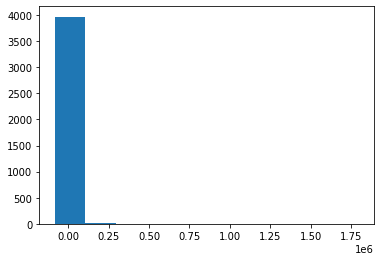

In [99]:
plt.hist(flat_samples[:,0])

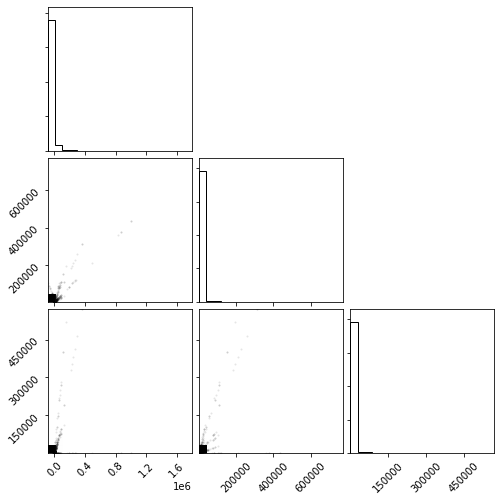

In [100]:
import corner
flat_samples.shape
fig = corner.corner(
    flat_samples
);

In [ ]:
plt.plot(sampler.get_chain(flat=True)[:,0])

In [ ]:
chain = sampler.get_chain()

In [ ]:
chain.shape

In [ ]:
for i in range(20):
    plt.plot(chain[:,i,0])

In [ ]:
for i in range(20):
    plt.plot(chain[:,i,1])